In [43]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math

In [44]:
tf.__version__

'0.12.0-rc0'

In [45]:
filter_size1 = 5
num_filters1 = 16

filter_size2 = 5
num_filters2 = 36

fc_size = 128

from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [46]:
# One-Hot labels so we can show numbers as integers for test-set.
# data.test.cls = np.argmax(data.test.lables, axis = 1)
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [47]:
data.test.cls = np.argmax(data.test.labels, axis =1)

In [48]:
img_size = 28
img_size_flat = img_size * img_size
img_shape = (img_size, img_size)
num_channels = 1
num_classes = 10

In [49]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

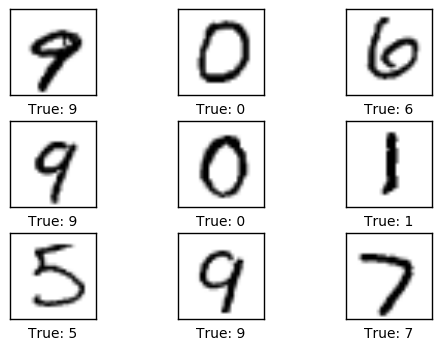

In [50]:
# Get the first images from the test-set.
images = data.test.images[9:18]

# Get the true classes for those images.
cls_true = data.test.cls[9:18]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [51]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [52]:
# A convolutional layer constructing function.
def new_conv_layer(input, num_input_channels, filter_size, num_filters, use_pooling=True):  

    # Shape of the filter-weights for the convolution.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Creating new filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)
    
    # A conv layer is created with params input, filter(which were quantified by weights), stides (which are values that dictate movement of the filter on top of the image)
    # Padding is "Same" and that means outpit size is the same as the input.
    layer = tf.nn.conv2d(input=input, filter=weights, strides=[1, 1, 1, 1], padding='SAME')

    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution (to 14 X 14  px)
    if use_pooling:
        layer = tf.nn.max_pool(value=layer, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    # Rectified Linear Unit (ReLU) (NON LINEARITY)
    layer = tf.nn.relu(layer)

    # We return both the resulting layer and weights are returned for easy plotting later.
    return layer, weights

In [53]:
# Accepts a 4d tensor from the CNN 
def flatten_layer(layer):
    layer_shape = layer.get_shape()
    # layer_shape = [num_images, img_height, img_width, num_channels]
    
    #The number of features is img_height * img_width * num_channels.
    num_features = layer_shape[1:4].num_elements()
    
    # The layer is reshaped. -1 means that the reshape does not affect that dimension, only the num_features dimension.
    # In short, -1 flattens the tensor.
    layer_flat = tf.reshape(layer, [-1, num_features])
    # layer_flat shape is now [num_images, num_features(img_height * img_width * num_channels)]
    
    return layer_flat, num_features
    
    
    
    

In [69]:
# Input here is a 2 dimensional tensor that was previously flatenned.
def new_fc_layer(input, num_inputs, num_outputs, use_relu=True):
    # Using earlier created helper functions
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)
    
    # Here the layer is actually calculated and the weights and biases do play a role.
    layer = tf.matmul(input, weights) + biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    
    return layer

In [70]:
# Means each input will be an input vector of [?, img_size_flat]
x = tf.placeholder(tf.float32, shape = [None, img_size_flat], name='x')

In [71]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, 10], name = 'y_true')

y_true_cls = tf.argmax(y_true, dimension=1)

In [72]:
layer_conv1, weights_conv1 = new_conv_layer(input=x_image, num_input_channels=num_channels, filter_size=filter_size1, num_filters=num_filters1, use_pooling=True)

In [73]:
layer_conv1

<tf.Tensor 'Relu_5:0' shape=(?, 14, 14, 16) dtype=float32>

In [74]:
layer_conv2, weights_conv2 = new_conv_layer(input=layer_conv1, num_input_channels=num_filters1, filter_size = filter_size2, num_filters = num_filters2, use_pooling=True)

In [75]:
layer_conv2

<tf.Tensor 'Relu_6:0' shape=(?, 7, 7, 36) dtype=float32>

In [76]:
layer_flat, num_features = flatten_layer(layer_conv2)

In [77]:
layer_flat

<tf.Tensor 'Reshape_5:0' shape=(?, 1764) dtype=float32>

In [78]:
num_features 

1764

In [79]:
# Creating the fully connecting layer by accepting input from the last layer_flat
layer_fc1 = new_fc_layer(input=layer_flat, num_inputs=num_features, num_outputs=fc_size, use_relu = True)   

In [80]:
layer_fc1

<tf.Tensor 'Relu_7:0' shape=(?, 128) dtype=float32>

In [ ]:
layer_fc2 = new_fc